In [1]:
import psycopg2
from sqlalchemy import create_engine

import ast

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%matplotlib inline

### Questions to answer

- What kind of projects are popular on Kickstarter?
- How much are people asking for?
- What kind of projects tend to be more funded?

### Connect to database

In [3]:
dbname="kick"
tblname="info"

In [4]:
engine = create_engine(
        'postgresql://localhost:5432/{dbname}'.format(dbname=dbname))

# Connect to database
conn = psycopg2.connect(dbname=dbname)
cur = conn.cursor()

Remind myself of the columns in the table:

In [5]:
cur.execute("SELECT column_name,data_type FROM information_schema.columns WHERE table_name = '{table}';".format(table=tblname))
rows = cur.fetchall()
pd.DataFrame(rows, columns=["column_name", "data_type"])

,column_name,data_type
0,index,integer
1,id,integer
2,photo,character varying
3,name,character varying
4,blurb,character varying
5,goal,double precision
6,pledged,double precision
7,state,character varying
8,slug,character varying
9,disable_communication,boolean


Number of records in table:

In [6]:
cur.execute("SELECT COUNT(*) from {table}".format(table=tblname))
cur.fetchone()

(177140,)

---

### Question 1: Project topics

- How many different types of projects are on Kickstarter?
- What is most popular?
- What is most rare?

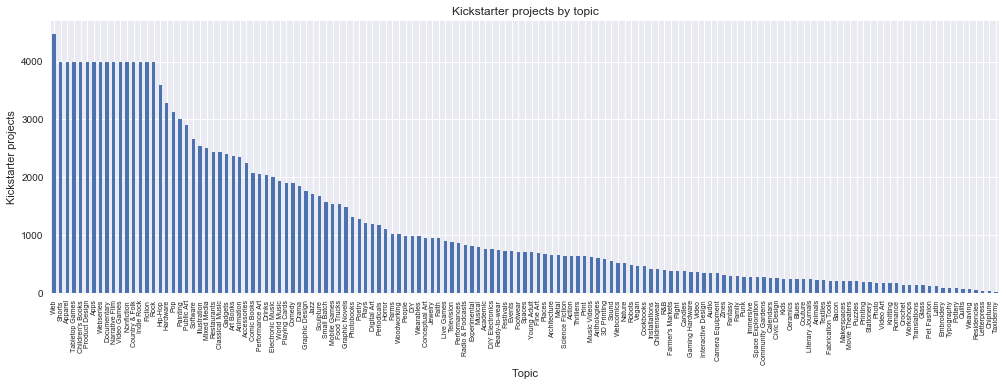

In [7]:
cur.execute("SELECT topic, COUNT(*) from {table} GROUP BY topic ORDER BY count DESC;".format(table=tblname))
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=["topic", "count"])

# Plot findings
plt.rcParams["figure.figsize"] = [17,5]

df.plot(kind="bar", x="topic", y="count", legend=False)

plt.ylabel("Kickstarter projects")
plt.xlabel("Topic")
plt.title("Kickstarter projects by topic")
plt.tick_params(axis='x', labelsize=7)

In [8]:
"There are {num_topics} different types of Kickstarter projects".format(num_topics=df.shape[0])

'There are 143 different types of Kickstarter projects'

In [9]:
# Most popular project topic is
df[df["count"] == df["count"].max()]

,topic,count
0,Web,4476


In [10]:
# Most rare project topic is
df[df["count"] == df["count"].min()]

,topic,count
142,Taxidermy,12


What are the rare projects?

In [11]:
cur.execute("SELECT id, blurb, goal*static_usd_rate as goal_usd FROM {table} WHERE topic = '{topic}'".format(table=tblname, topic="Taxidermy"))
rows = cur.fetchall()
for row in rows:
    row_id, blurb, goal = row
    print(">>> $%d | id: %s" % (goal, row_id),
          blurb, sep="\n")

>>> $8319 | id: 2009417734
Master prop maker and creator of the dead fairy hoax that captured the world’s imagination invites you into his studio to reveal all!
>>> $4300 | id: 874566085
Gallery | Public Dissections | Events |
A space in downtown San Francisco to reflect upon the less considered means of living & dying.
>>> $5000 | id: 304809544
TaxiClear transforms biology into brilliant works of art that illustrate the beauty and complexity of life
>>> $500 | id: 1111529080
Insects: the most abundant and intriguing organisms on Earth. May be seen as pests but are works of art that I will add to wreaths.
>>> $3000 | id: 48529158
I take my passion for leather working and create hand carved notebook covers to honor a person's legacy and career accomplishments.
>>> $2000 | id: 588593322
Casting skulls from rare and unique species of animal.  To include miniature skulls in the future.
>>> $705 | id: 1539840572
The "Meteor Grip" ergonomic craft, taxidermy knife fro precise accurate cutting

### Question 2: Project funding goals
- How much are people asking for in general? by topics?

In [12]:
sql = "SELECT id, topic, goal*static_usd_rate as goal_usd FROM {table}".format(table=tblname)
cur.execute(sql)
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=["id", "topic", "goal_usd"])

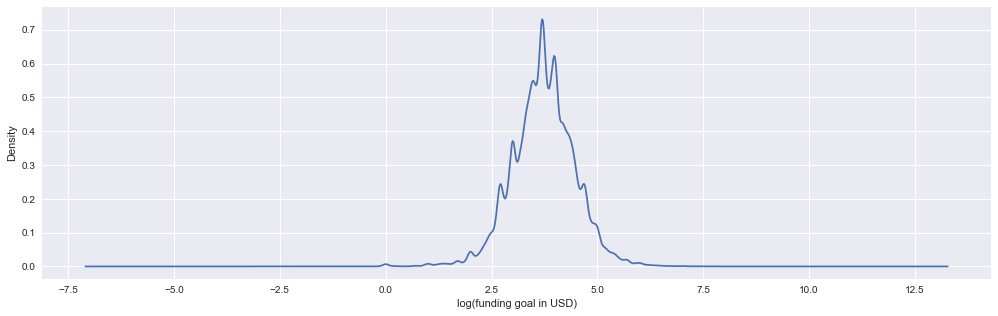

In [13]:
# Asking average
np.log10(df.goal_usd).plot.kde()
plt.xlabel("log(funding goal in USD)")

In [14]:
"Most projects are asking for: $%d - $%d" % (10**2.5, 10**5)

'Most projects are asking for: $316 - $100000'

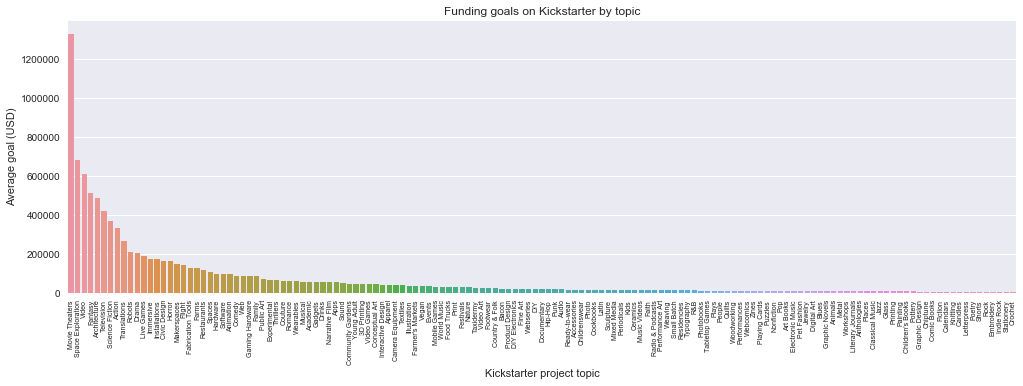

In [15]:
sns.barplot(x="topic", y="goal_usd",
              data=df.groupby("topic").mean().reset_index().sort_values(by="goal_usd", ascending=False))

_ = plt.xticks(rotation='vertical')
plt.ylabel("Average goal (USD)")
plt.xlabel("Kickstarter project topic")
plt.title("Funding goals on Kickstarter by topic")
plt.tick_params(axis='x', labelsize=7)

"Movie Theaters" and "Space exploration" have the average higest funding goals

### Question 3: Funding success

What tends to get funded?

In [16]:
sql = "SELECT id, topic, goal, pledged, pledged/goal as progress FROM info ORDER BY progress DESC;"
cur.execute(sql)
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=["id", "topic", "goal", "pledged", "progress"])

In [17]:
df["well_funded"] = df.progress >= 1

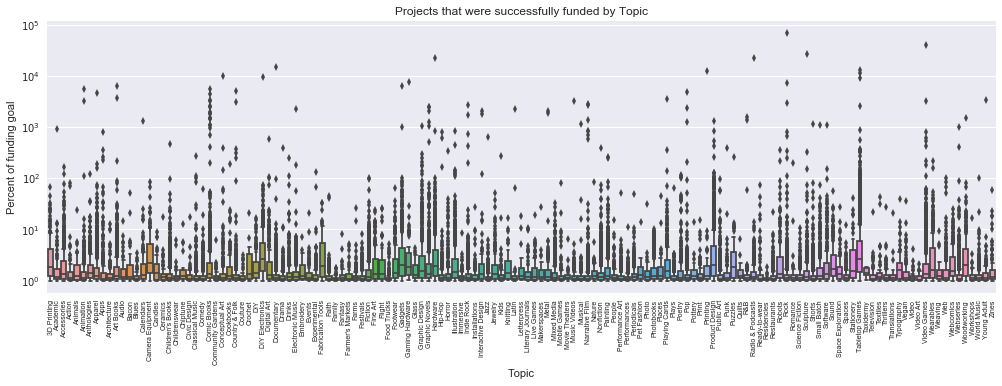

In [18]:
plt.rcParams["figure.figsize"] = [17,5]
sns.boxplot(x="topic", y="progress", data=df[df.well_funded].sort_values(by="topic"))
_ = plt.xticks(rotation='vertical')

plt.yscale('log')

plt.ylabel("Percent of funding goal")
plt.xlabel("Topic")
plt.title("Projects that were successfully funded by Topic")
plt.tick_params(axis='x', labelsize=7)

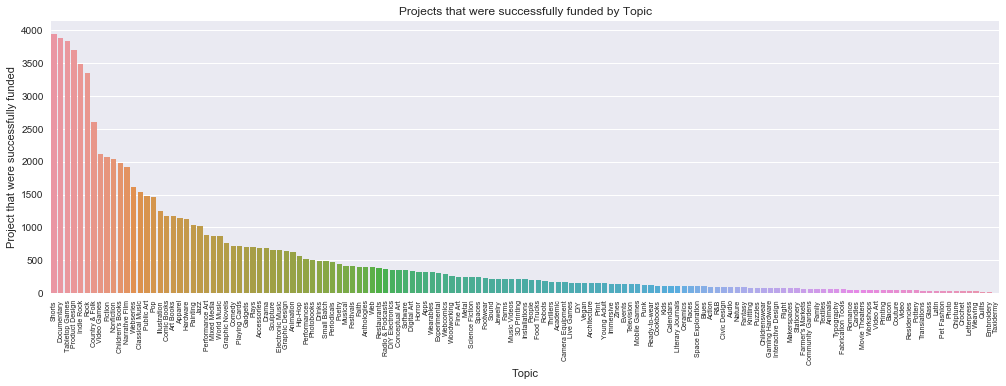

In [19]:
sns.barplot(x="topic", y="progress",
            data=df[df.well_funded].groupby("topic").count().reset_index().sort_values(by="progress", ascending=False))
_ = plt.xticks(rotation='vertical')

plt.ylabel("Project that were successfully funded")
plt.xlabel("Topic")
plt.title("Projects that were successfully funded by Topic")
plt.tick_params(axis='x', labelsize=7)

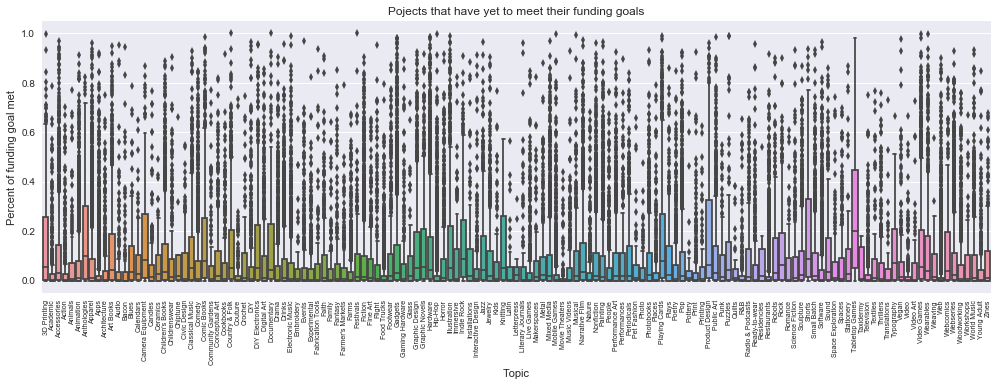

In [20]:
plt.rcParams["figure.figsize"] = [17,5]
sns.boxplot(x="topic", y="progress",
            data=df[np.invert(df.well_funded)].sort_values(by="topic"))
_ = plt.xticks(rotation='vertical')

plt.ylabel("Percent of funding goal met")
plt.xlabel("Topic")
plt.title("Pojects that have yet to meet their funding goals")
plt.tick_params(axis='x', labelsize=7)

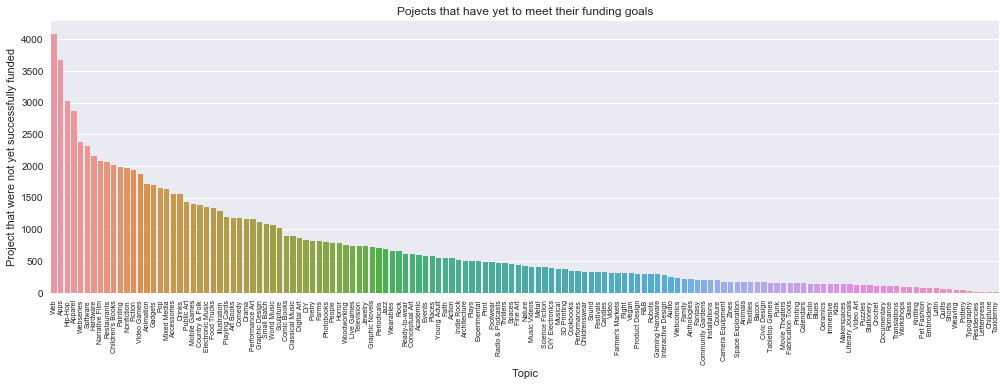

In [21]:
sns.barplot(x="topic", y="progress",
            data=df[np.invert(df.well_funded)].groupby("topic").count().reset_index().sort_values(by="progress", ascending=False))
_ = plt.xticks(rotation='vertical')

plt.ylabel("Project that were not yet successfully funded")
plt.xlabel("Topic")
plt.title("Pojects that have yet to meet their funding goals")
plt.tick_params(axis='x', labelsize=7)

### Close connection

In [22]:
# close communication with the PostgreSQL database server
cur.close()

# commit the changes
conn.commit()

# close connection
conn.close()